In [77]:
import matplotlib
import bettermoments as bm
import numpy as np

from multiprocessing import Pool
import matplotlib.pyplot as plt
from eddy.rotationmap import rotationmap
from matplotlib.backends.backend_pdf import PdfPages
import corner
import pandas as pd
from tqdm import tqdm

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import Angle
from disk_dictionary2 import disk_dict
from disk_dictionary2 import get_dict
import os

from pypdf import PdfMerger
import skimage 
from fpdf import FPDF
from astropy.wcs import WCS
from matplotlib.patches import Ellipse
#https://bulk.cv.nrao.edu/deco/users/cjlaw/IMAGING/
%matplotlib inline
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable
import pdfkit
import emcee
import pathlib

In [264]:
def process_data(infile, data, velax, m_values,  sigma_clip, background_v):

    rms = bm.estimate_RMS(data=data, N=5)



    # define mask based on carta
    m = np.zeros(data.shape[0])
    if m_values[0] == 'full':
        m1,m2,m3,m4 = 0, len(m), 0, len(m)
    else:
        m1,m2,m3,m4 = m_values
    
    m[m1:m2] = 1
    m[m3:m4] = 1


    channel_mask = bm.get_channel_mask(data=data, user_mask=m)
    threshold_mask = bm.get_threshold_mask(data=data, clip=sigma_clip)

    data_masked = data * channel_mask * threshold_mask

    # if pos_mask == None:
    #     data_masked = data * channel_mask * threshold_mask
    # else:
    #     data_masked = data * channel_mask * threshold_mask*pos_mask


    #v0, dv0, Fnu, dFnu = bm.collapse_quadratic(velax, data, rms)
    moments = bm.collapse_quadratic(velax, data_masked, rms)
    v0, dv0, Fnu, dFnu = moments

    print('Collapsed')

    bad_indices =  v0<=np.median(v0) 

    v0[bad_indices] = np.nan
    dv0[bad_indices] = np.nan
    Fnu[bad_indices] = np.nan
    dFnu[bad_indices] = np.nan

    min_v0, max_v0 = np.min(v0), np.max(v0)

    bm.save_to_FITS(moments =(v0, dv0, Fnu, dFnu), method='quadratic', path=infile)

    return min_v0, max_v0, moments, data.shape

def create_postage_stamps(infile):

    data, velax = bm.load_cube(infile)

    name = infile.split('/')[-1].split('_')[0]
    emission_line = infile.split('/')[-1].split('_')[1]

    data_size = int(np.round(len(data[0])/2))
    fov = 100
    nrows = 4
    ncols = 5
    f, axes = plt.subplots(nrows, ncols, figsize= (15,15))
    channel_vals = np.arange(10,210,10)

    for nrow in tqdm(range(nrows)):
        for ncol in range(ncols):
            ax = axes[nrow][ncol]
            channel = channel_vals[5*nrow+ncol]
            im = ax.imshow(data[channel][data_size-fov:data_size+fov, data_size-fov:data_size+fov])
            ax.set_title(f'Channel: {channel}')
        
    plt.suptitle(f'{name}, {emission_line}')
    plt.show()

    return f, data, velax

def create_velocity_map(infile, m_values, beam, v0, v_scaling, contours, clevels, mask): 


    m1, m2,m3,m4 = m_values

    name = infile.split('/')[-1].split('_')[0]
    region = infile.split('/')[-2]

    hdul = fits.open(infile)  # open as FITS file
    hdr = hdul[0].header  # the primary HDU header
    dec = hdr['CRVAL2'] 
    ra = hdr['CRVAL1'] 


    center_ra = disk_dict[region][name]['RA']
    center_dec = disk_dict[region][name]['Dec']

    print('center',center_ra, center_dec)
    print(Angle(center_ra * u.degree).hms,Angle(center_dec * u.degree).dms)
    # center_ra, center_dec = 164.75512575819914, -77.37824095879179
    

    ra_diff_arcsecond = (center_ra - ra) * np.cos(dec*np.pi/180)*3600
    dec_diff_arcsecond = (center_dec - dec) * 3600


    ## do Eddy stuff
    name = infile.split('/')[-1].split('_')[0]
    cube = rotationmap(path=f'{infile[:-5]}_v0.fits',
                    uncertainty=f'{infile[:-5]}_dv0.fits',
                    FOV=beam)

    # v_scaling = np.nanmin(v0[575:675, 575:675])/1000, np.nanmax(v0[575:675, 575:675])/1000
    rot_fig = cube.plot_data(vmin=v_scaling[0], vmax=v_scaling[1], return_fig=True)
    rot_axes_list = rot_fig.axes
    rot_axes_list[0].set_title('Channels: '+f'{m1}-{m2},{m3}-{m4}')
    rot_axes_list[0].scatter(ra_diff_arcsecond, dec_diff_arcsecond, color='black',s=20)


    for wcscont_num in range(len(contours)): 
        wcscont = contours[wcscont_num]
        if wcscont_num == 0:
            print((wcscont[1][0]),(wcscont[0][0]))
            rot_axes_list[0].plot((wcscont[1]-ra)*3600*np.cos(dec*np.pi/180),(wcscont[0]-dec)*3600,color='black',label=f'Continuum Contour at {clevels}',ls='--')
        else:
            print('plotting')
            rot_axes_list[0].plot((wcscont[1]-ra)*3600*np.cos(dec*np.pi/180),(wcscont[0]-dec)*3600,color='black',ls='--')

    rot_fig.suptitle(name)

    if mask != None:
        if len(mask) == 3:
            ellipse = Ellipse((ra_diff_arcsecond,dec_diff_arcsecond), width=2*mask[0], height=2*mask[1], angle=mask[2], edgecolor='black', ls='dotted',facecolor='none',label='mask')
        else:
            ellipse = Ellipse((mask[3],mask[4]), width=2*mask[0], height=2*mask[1], angle=mask[2], edgecolor='black', ls='dotted',facecolor='none',label='mask')

        # Add ellipse to plot
        plt.gca().add_patch(ellipse)



    plt.legend()

    return cube, rot_fig, (ra_diff_arcsecond,dec_diff_arcsecond), v_scaling


def remove_background(moments, infile, background_v, mask, beam, v_scaling, offsets, data_shape):



    v0, dv0, Fnu, dFnu = moments

    if background_v != None:
        print('erasing background')
        background_indices = v0 <= background_v*1000

        v0[background_indices] = np.nan
        dv0[background_indices] = np.nan
        Fnu[background_indices] = np.nan
        dFnu[background_indices] = np.nan

    bm.save_to_FITS(moments =(v0, dv0, Fnu, dFnu), method='quadratic', path=infile)

    masked_cube = rotationmap(path=f'{infile[:-5]}_v0.fits',
                uncertainty=f'{infile[:-5]}_dv0.fits',
                FOV=beam)

    if mask != None:
        ellipse_mask = create_ellipse_array(mask[0], mask[1], mask[2], [offsets[0],offsets[1]], infile, data_shape)
        for vfile in [f'{infile[:-5]}_v0.fits', f'{infile[:-5]}_dv0.fits']:
            hdul = fits.open(vfile)
            image_data = hdul[0].data  # Assuming the image data is in the primary HDU
            image_data = np.flipud(image_data)

            masked_image_data = image_data * ellipse_mask
            bad_indices =  masked_image_data == 0
            masked_image_data[bad_indices] = np.nan

            masked_image_data = np.flipud(masked_image_data)
            
            hdul[0].data = masked_image_data
            hdul.writeto(f'{vfile[:-5]}_masked.fits', overwrite=True)
            hdul.close()


        masked_cube = rotationmap(path=f'{infile[:-5]}_v0_masked.fits',
                    uncertainty=f'{infile[:-5]}_dv0_masked.fits',
                    FOV=beam)

    # v_scaling = np.nanmin(v0[575:675, 575:675])/1000, np.nanmax(v0[575:675, 575:675])/1000
    masked_no_bkg_rot_fig = masked_cube.plot_data(vmin=v_scaling[0], vmax=v_scaling[1], return_fig=True)

    name = infile.split('/')[-1].split('_')[0]

    masked_no_bkg_rot_fig.axes[0].set_title(f'Masked Data, with Background Subtraction [km/s] = {background_v}')
    plt.suptitle(name)

    return masked_no_bkg_rot_fig, masked_cube


def mask_cube(ellipse_mask, infile, beam, v_scaling):

    for vfile in [f'{infile[:-5]}_v0.fits', f'{infile[:-5]}_dv0.fits']:
        hdul = fits.open(vfile)
        image_data = hdul[0].data  # Assuming the image data is in the primary HDU
        image_data = np.flipud(image_data)

        masked_image_data = image_data * ellipse_mask
        bad_indices =  masked_image_data == 0
        masked_image_data[bad_indices] = np.nan

        masked_image_data = np.flipud(masked_image_data)
        
        hdul[0].data = masked_image_data
        hdul.writeto(f'{vfile[:-5]}_masked.fits', overwrite=True)
        hdul.close()

    masked_cube = rotationmap(path=f'{infile[:-5]}_v0_masked.fits',
                uncertainty=f'{infile[:-5]}_dv0_masked.fits',
                FOV=beam)
    

    masked_cube.plot_data(vmin=v_scaling[0], vmax=v_scaling[1])

    plt.title("masked data")
    plt.show()
    return masked_cube


def run_eddy_mcmc(cube, offsets, annulus, PA_guess, vlsr_guess, nwalkers, nburn, nsims, move_stretch=2, scatter=1e-3):

    name = infile.split('/')[-1].split('_')[0]
    region = infile.split('/')[-2]
    # Dictionary to contain the disk parameters.
    mass_prior =  disk_dict[region][name]['M_star']
    distance =   disk_dict[region][name]['distance']
    lit_inc =   disk_dict[region][name]['inclination']

    print(f'SET -- x_offset: {offsets[0]}, y_offset: {offsets[1]}, mass: {mass_prior}, distance: {distance}, inc: {lit_inc}')


    params = {}



    # Start with the free variables in p0.
    params['PA'] = 0

    if lit_inc != '--' and lit_inc != 0:
        print('fixing inclination')
        params['vlsr'] = 1
        params['mstar'] = 2
        params['inc'] = float(lit_inc) # degrees
        p0 = [PA_guess,vlsr_guess*1000, mass_prior, ]
    else:
        print('fixing mass')
        params['vlsr'] = 1
        params['inc'] = 2
        params['mstar'] = mass_prior
        p0 = [PA_guess, vlsr_guess*1000, 20]


    params['x0'] = offsets[0]
    params['y0'] = offsets[1]
    params['dist'] = distance   # parsec


    params['r_min'] = float(annulus[0]) if annulus[0] != None else None
    params['r_max'] = float(annulus[1]) if annulus[1] != None else None

    if move_stretch > 0:
        moves = emcee.moves.StretchMove(a=move_stretch)
    else:
        print("Using Differential Evolution Move")
        moves = emcee.moves.DEMove()

    samples, resid_fig = cube.fit_map(p0=p0, params=params,
                        nwalkers=nwalkers, nburnin=nburn, nsteps=nsims, mcmc_kwargs = {'moves':moves, 'scatter':scatter})



    return samples, params, resid_fig 

def plot_model_and_resids(samples, params, v_scaling, rot_fig, masked_no_bkg_rot_fig, resid_fig, disk_row, postage_stamp_fig, cont_fig):

    name = infile.split('/')[-1].split('_')[0]
    region = infile.split('/')[-2]
    line = infile.split('/')[-1].split('_')[1]

    PA = np.median([x[0] for x in samples])
    PA_err_plus, PA_err_minus = np.percentile([x[0] for x in samples],84), np.percentile([x[0] for x in samples],16)

    model = cube.evaluate_models(samples=samples, params=params)
    model_fig = cube.plot_model(model=model, return_fig = True, imshow_kwargs = {'vmin': v_scaling[0], 'vmax': v_scaling[1]})

    axes_list = model_fig.axes

    PA_slope = np.tan((PA+90)*np.pi / 180)
    PA_slope_plus = np.tan((PA_err_plus+90)*np.pi / 180)
    PA_slope_minus = np.tan((PA_err_minus+90)*np.pi / 180)


    x= np.arange(-5,5,.1)
    PA_line = -x * PA_slope
    PA_line_plus = -x * PA_slope_plus
    PA_line_min = -x * PA_slope_minus

    ra_diff_arcsecond, dec_diff_arcsecond = params['x0'], params['y0']

    axes_list[0].scatter(ra_diff_arcsecond, dec_diff_arcsecond, color='black',s=20)

    
    axes_list[0].plot(x+ra_diff_arcsecond,PA_line_plus+dec_diff_arcsecond,color='black',ls='-',linewidth=1)
    axes_list[0].plot(x+ra_diff_arcsecond,PA_line_min+dec_diff_arcsecond,color='black',ls='-',linewidth=1)


    model_fig.suptitle(f"{infile.split('/')[-1].split('_')[0]}",fontsize=15)
    axes_list[0].set_title(f"PA: {np.round(PA,1)}$^\degree$"+f" -- Offset ({np.round(ra_diff_arcsecond,2)},{np.round(dec_diff_arcsecond,2)})", fontsize=13,pad=5)
    axes_list[0].scatter(ra_diff_arcsecond,dec_diff_arcsecond,s=50,color='black')
    name = infile.split('/')[-1].split('_')[0]


    # resid_fig = cube.plot_model_residual(model=model, return_fig=True)


    rot_fig.axes[0].plot(x+params['x0'],PA_line_plus+params['y0'],color='black',linewidth=1)
    rot_fig.axes[0].plot(x+params['x0'],PA_line_min+params['y0'],color='black',linewidth=1)




    corner_fig = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], labels=[l for l in list(params.keys())[0:len(samples[0])]], label_kwargs={"fontsize": 15}, show_titles=True, bins= 60)



    figs = [postage_stamp_fig, cont_fig, rot_fig,masked_no_bkg_rot_fig,model_fig,resid_fig,corner_fig] # list of figures
    pdf_file_path = f'/Users/calebpainter/Downloads/DECO/disk_plots_v/full_diagnostic_{name}_{line}_{nsims}_sim_{nwalkers}_walkers.pdf'
    with PdfPages(pdf_file_path) as pdf:
        for fig in figs:
            pdf.savefig(fig, bbox_inches='tight') 


    with open(f'/Users/calebpainter/Downloads/DECO/disk_rows/{name}_{line}.txt','w') as f:  
        for key, value in disk_row.items():  
                f.write('%s:     %s\n' % (key, value))    
    pdf = FPDF()   
    pdf.add_page()
    pdf.set_font("Arial", size = 8)
    f = open(f'/Users/calebpainter/Downloads/DECO/disk_rows/{name}_{line}.txt', 'r')
    for x in f:
        pdf.cell(200, 10, txt = x, ln = 1, align = 'L')
    pdf.output(f'/Users/calebpainter/Downloads/DECO/disk_rows/{name}_{line}.pdf')   

    pdfs = [pdf_file_path,f'/Users/calebpainter/Downloads/DECO/disk_rows/{name}_{line}.pdf']

    merger = PdfMerger()

    for pdf in pdfs:
        merger.append(pdf)

    merger.write(f'/Users/calebpainter/Downloads/DECO/disk_plots_v/final_diagnostic_plots/full_diagnostic_with_dict_{line}_{region}_{name}_{nsims}_sim_{nwalkers}_walkers.pdf')
    merger.close()

    pathlib.Path.unlink(pdf_file_path)

    return model_fig, resid_fig, rot_fig


def get_cont_file(infile):
    name = infile.split('/')[-1].split('_')[0]

    file_dir = '/Users/calebpainter/Downloads/products/new'
    file_dirs = os.listdir(file_dir)
    all_cont_files = []
    for fdir in file_dirs:
        try:
            new_dir = file_dir+'/'+fdir+'/cont_images/'
            region_files = os.listdir(new_dir)
            all_cont_files.append([new_dir + x for x in region_files])
        except:
            pass

    disk_cont_file = None

    for sublist in all_cont_files:
        for item in sublist:
            if name in item:
                disk_cont_file = item
    print(disk_cont_file)
    return disk_cont_file

def plot_fits(infile, image_file, fov):
    


    hdu_list = fits.open(image_file, mode='update')
    print(hdu_list.info())

    header = hdu_list[0].header
    key = 'TIMESYS'
    header[key] = header[key].replace('UTC', 'utc')

    # Save changes and close
    hdu_list.flush()
    hdu_list.close()

    hdu_list = fits.open(image_file)

    og_image_data = hdu_list[0].data
    og_image_data = og_image_data.squeeze()

    image_data = og_image_data[(int(np.round(len(og_image_data)/2)) - fov):(int(np.round(len(og_image_data)/2))+fov), (int(np.round(len(og_image_data)/2)) - fov):(int(np.round(len(og_image_data)/2))+fov)]
    print(np.nanmax(image_data))
    image_data = image_data / np.nanmax(image_data)
    print(np.nanmax(image_data))
        
    wcs = WCS(hdu_list[0].header)  #
    wcs_proj = wcs.slice([0,1])

    print(wcs)

    cont_fig, ax = plt.subplots(1,1, figsize=(6,6),subplot_kw={'projection': wcs_proj})
    im = ax.imshow(image_data)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.5)

    cont_fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title("Continuum Stamp")

    dec = header['CRVAL2'] 
    ra = header['CRVAL1'] 
    print('obs center', (ra,dec))

    dec_scale = header['CDELT2'] 
    ra_scale = header['CDELT1'] 

    name = infile.split('/')[-1].split('_')[0] 
    region = infile.split('/')[-2]
    # Dictionary to contain the disk parameters.
    disk_center_ra =  disk_dict[region][name]['RA']
    disk_center_dec =  disk_dict[region][name]['Dec']
    print(disk_center_ra,disk_center_dec)

    disk_center_ra -= ra
    disk_center_dec -= dec

    disk_center_ra /= (ra_scale)
    disk_center_dec /= (dec_scale)

    ax.scatter(int(np.round(len(image_data)/2))+disk_center_ra,int(np.round(len(image_data)/2))+disk_center_dec,color='white',s=10, marker='x')

    print('size', int(np.round(len(og_image_data)/2)))

    skcontours = []
    skcontours_wcs = []
    contour_levels = [.1, .3, .50, .90]
    for level in contour_levels: 
        skcontour = skimage.measure.find_contours(image_data,level =level)
        skcontours.append(skcontour)

        for contour in skcontour:
            y, x = contour.T  # Extract contour coordinates
            lat, lon, _, _ = wcs.all_pix2world(x + (int(np.round(len(og_image_data)/2)) - fov), y + (int(np.round(len(og_image_data)/2)) - fov), 0, 0, 0) # Convert to RA, DEC
            skcontours_wcs.append([lon, lat])

    skcontours_wcs2 = []
    for skcontour in skcontours:
        # try:
        ax.plot([x[1] for x in skcontour[0]],[x[0] for x in skcontour[0]],color='white')
        skcontours_wcs2.append([np.array([x[1] - fov for x in skcontour[0]])*(ra_scale)+ra, np.array([x[0] -fov for x in skcontour[0]])*(dec_scale)+dec])
        # except:
        #     print("bad")

    return skcontours, skcontours_wcs, contour_levels, cont_fig, skcontours_wcs2

def create_ellipse_array(a, b, theta, center, infile, data_shape):

    depth = data_shape[0]
    size= data_shape[1]



    hdul = fits.open(f'{infile[:-5]}_v0.fits')  # open as FITS file
    hdr = hdul[0].header  # the primary HDU header
    dec_scale = hdr['CDELT2'] 
    ra_scale = hdr['CDELT1'] 

    a /= (ra_scale*3600)
    b /= (dec_scale*3600)

    center[0] /= (np.abs(ra_scale)*3600*size/2)
    center[1] /= (np.abs(dec_scale)*3600*size/2)

    print(a,b)
    a /= (size/2)
    b /= (size/2)

    print(a,b)
    theta += 90
    
    # Create a grid of size x size
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)
    
    # Convert angle from degrees to radians
    theta_rad = np.deg2rad(theta)
    
    print('center',center)
    print(a,b)
    # Compute the equation of the ellipse
    ellipse_eq = (((X+center[0]) * np.cos(theta_rad) + (Y+center[1]) * np.sin(theta_rad))**2 / b**2 
                  + ((X+center[0]) * np.sin(theta_rad) - (Y+center[1]) * np.cos(theta_rad))**2 / a**2)
    
    # Create mask for points inside the ellipse
    ellipse_mask = ellipse_eq <= 1
    
    return ellipse_mask.astype(int)  # Convert boolean array to integer (0 or 1)

def removekey(d, key):
    r = dict(d)
    del r[key]
    return r



def get_file(region_num, file_num):
    all_files = []
    '''Lupus'''
    region_dir = '/Users/calebpainter/Downloads/DECO/fits_files/Lupus/'
    infiles = infiles = [region_dir+x for x in os.listdir(region_dir) if x[-10:]=='image.fits']
    all_files.append(infiles)

    '''ROph'''
    region_dir = '/Users/calebpainter/Downloads/DECO/fits_files/ROph/'
    infiles = infiles = [region_dir+x for x in os.listdir(region_dir) if x[-10:]=='image.fits']
    all_files.append(infiles)

    '''ChamI'''
    region_dir = '/Users/calebpainter/Downloads/DECO/fits_files/ChamI/'
    infiles = infiles = [region_dir+x for x in os.listdir(region_dir) if x[-10:]=='image.fits']
    all_files.append(infiles)

    infile = all_files[region_num][file_num]
    print(f'File Group:\n')
    for file in all_files[region_num]:
        print(file+'\n')
    print('Disk File: ', all_files[region_num][file_num])

    return infile


In [192]:
region_num = 1
file_num = 0
infile = get_file(region_num, file_num)

File Group:

/Users/calebpainter/Downloads/DECO/fits_files/ROph/J162738.3-243658_CO_230.538GHz.image.fits

/Users/calebpainter/Downloads/DECO/fits_files/ROph/J162739.0-235818_CO_230.538GHz.image.fits

/Users/calebpainter/Downloads/DECO/fits_files/ROph/J162730.2-242743_CO_230.538GHz.image.fits

/Users/calebpainter/Downloads/DECO/fits_files/ROph/J162618.9-242820_CO_230.538GHz.image.fits

/Users/calebpainter/Downloads/DECO/fits_files/ROph/J162733.1-244115_CO_230.538GHz.image.fits

/Users/calebpainter/Downloads/DECO/fits_files/ROph/J162649.0-243825_CO_230.538GHz.image.fits

/Users/calebpainter/Downloads/DECO/fits_files/ROph/J162616.8-242223_CO_230.538GHz.image.fits

/Users/calebpainter/Downloads/DECO/fits_files/ROph/J162636.8-241552_CO_230.538GHz.image.fits

/Users/calebpainter/Downloads/DECO/fits_files/ROph/J162656.8-241351_CO_230.538GHz.image.fits

/Users/calebpainter/Downloads/DECO/fits_files/ROph/J162624.1-241613_CO_230.538GHz.image.fits

/Users/calebpainter/Downloads/DECO/fits_files/R

/Users/calebpainter/Downloads/products/new/RhoOph_CCH_setting/cont_images/member.uid___A001_X2d20_X1f1f.J162738.3-243658_sci.spw25_27_29_31_33_35_37_39_41_43.cont.I.pbcor.fits
Filename: /Users/calebpainter/Downloads/products/new/RhoOph_CCH_setting/cont_images/member.uid___A001_X2d20_X1f1f.J162738.3-243658_sci.spw25_27_29_31_33_35_37_39_41_43.cont.I.pbcor.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     333   (768, 768, 1, 1)   float32   
None
0.029602844
1.0
WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN' 'DEC--SIN' 'FREQ' 'STOKES' 
CRVAL : np.float64(246.90953875) np.float64(-24.61627333333) np.float64(256565186441.8) np.float64(1.0) 
CRPIX : np.float64(385.0) np.float64(385.0) np.float64(1.0) np.float64(1.0) 
PC1_1 PC1_2 PC1_3 PC1_4  : np.float64(1.0) np.float64(0.0) np.float64(0.0) np.float64(0.0) 
PC2_1 PC2_2 PC2_3 PC2_4  : np.float64(0.0) np.float64(1.0) np.float64(0.0) np.float64(0.0) 
PC3_1 PC3_2 PC3_3 PC3_4  : np.floa

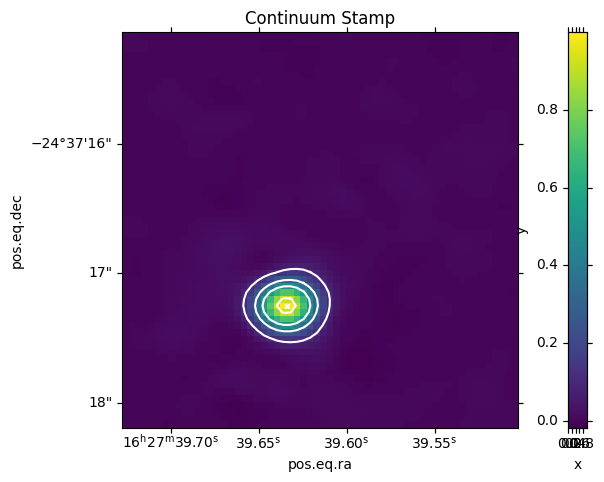

In [126]:
#Grab corresponding Continuum File
disk_cont_file = get_cont_file(infile)
skcontours, skcontours_wcs, contour_levels, cont_fig, skcontours_wcs2 = plot_fits(infile,disk_cont_file, 30)

100%|██████████| 4/4 [00:00<00:00, 565.69it/s]


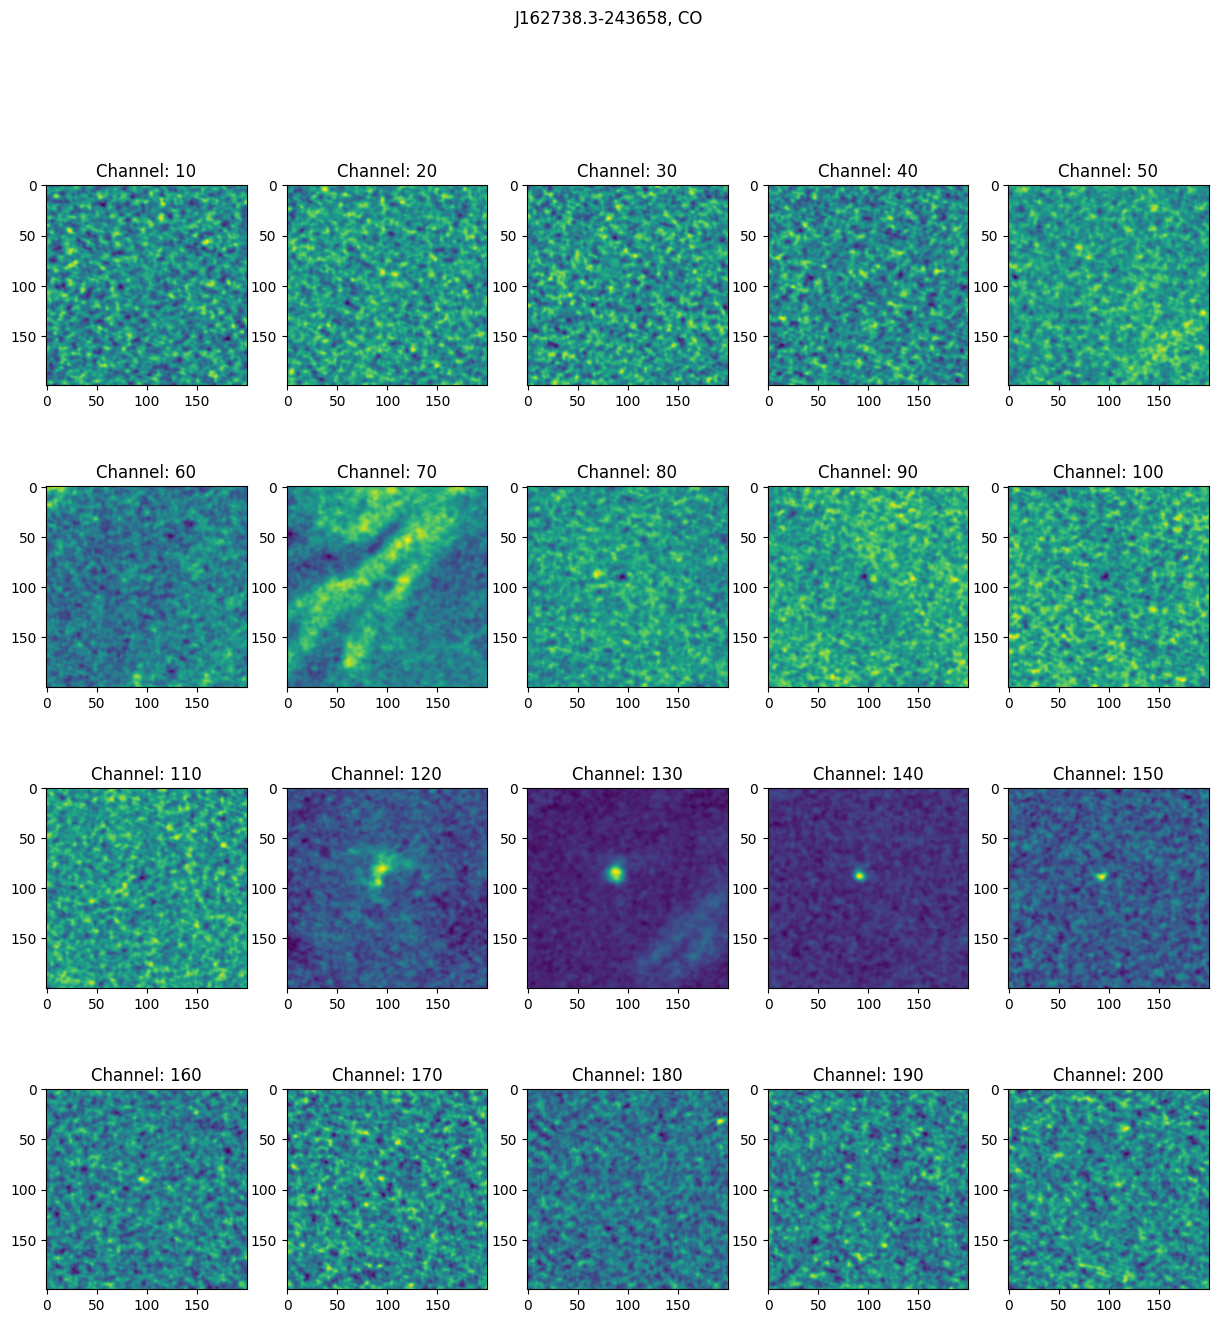

In [127]:
postage_stamp_fig, data, velax = create_postage_stamps(infile)

In [251]:
channels = 120, 180, 120, 180
min_v0, max_v0, moments, data_shape = process_data(infile, data, velax, channels,4, background_v)
v0 = moments[0]

Collapsed


center 246.9096170833333 -24.616443055555557
hms_tuple(h=np.float64(16.0), m=np.float64(27.0), s=np.float64(38.308099999999286)) dms_tuple(d=np.float64(-24.0), m=np.float64(-36.0), s=np.float64(-59.195000000004825))
246.9095699157678 -24.616371049593994
plotting
plotting
plotting


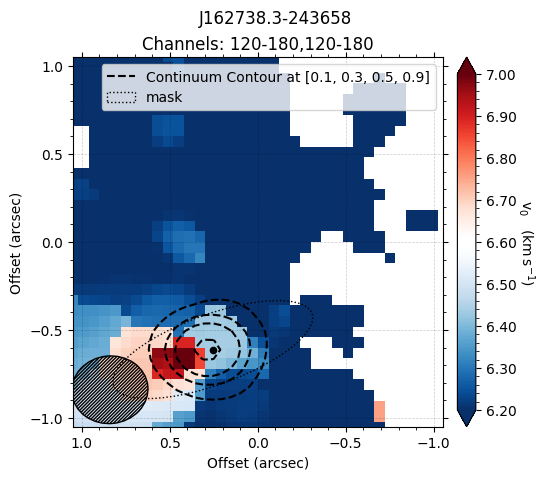

In [252]:
mask = [.6,.2,-20]
# mask = None
beam = 2
v_scaling = (6.2,7)  
background_v = 6.2
cube, rot_fig, offsets, v_scaling = create_velocity_map(infile, channels, beam, v0, v_scaling, skcontours_wcs, contour_levels, mask)

erasing background
-9.999999999998 3.333333333332667
-0.02469135802468642 0.008230452674895474
center [np.float64(0.010520787527657399), np.float64(-0.025173163786423564)]
-0.02469135802468642 0.008230452674895474


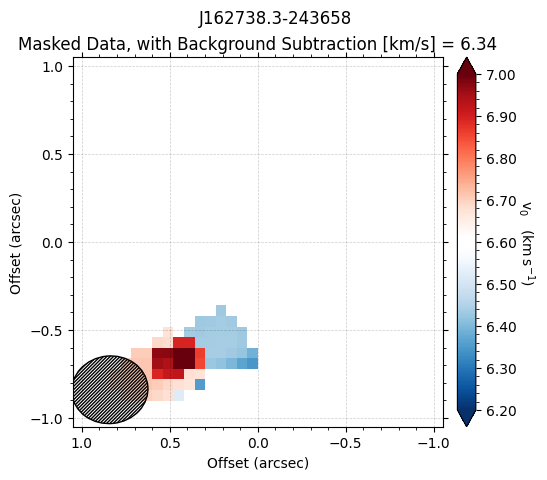

In [253]:
# remove background
background_v = 6.34
masked_no_bkg_rot_fig, masked_cube = remove_background(moments, infile, background_v, mask, beam, v_scaling, offsets, data_shape)

SET -- x_offset: 0.25565513692212594, y_offset: -0.6117078800102149, mass: 0.65, distance: 139.46, inc: 69.5808719937306
fixing inclination
Using Differential Evolution Move
Changed File
Assuming:
	p0 = [PA, vlsr, mstar].
Starting positions:
	p0 = ['1.10e+02', '6.60e+03', '6.50e-01']
scatter 0.001
original p0 [1.1e+02 6.6e+03 6.5e-01]
scatter p0 [[1.10071783e+02 6.60938591e+03 6.49503934e-01]
 [1.10036652e+02 6.59890225e+03 6.50671010e-01]
 [1.09865672e+02 6.58637709e+03 6.49817679e-01]
 [1.10059125e+02 6.59852152e+03 6.49950039e-01]
 [1.10079152e+02 6.60819284e+03 6.49766213e-01]
 [1.10017905e+02 6.58170885e+03 6.50702456e-01]
 [1.09788785e+02 6.60087574e+03 6.50119171e-01]
 [1.10078067e+02 6.60820029e+03 6.49609103e-01]
 [1.10043329e+02 6.58755129e+03 6.50197683e-01]
 [1.10059277e+02 6.59570942e+03 6.50259981e-01]
 [1.09937613e+02 6.59534154e+03 6.50824495e-01]
 [1.10206262e+02 6.60482851e+03 6.50499507e-01]
 [1.10180011e+02 6.60222799e+03 6.50106366e-01]
 [1.10048335e+02 6.59869815e

100%|██████████| 1300/1300 [00:00<00:00, 2555.60it/s]


Acceptance rate: 0.00


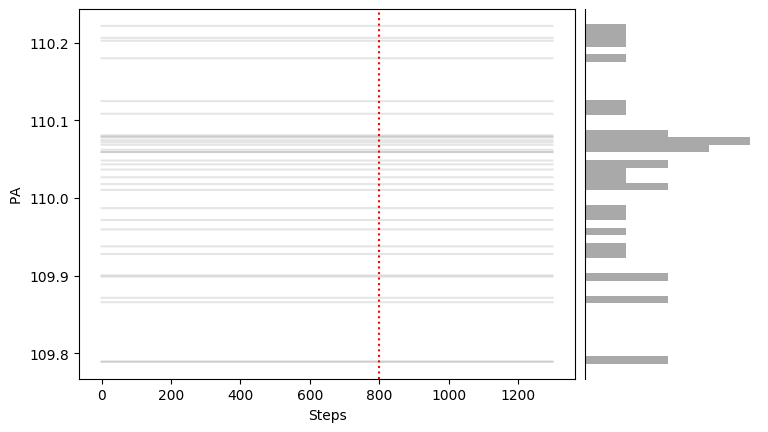

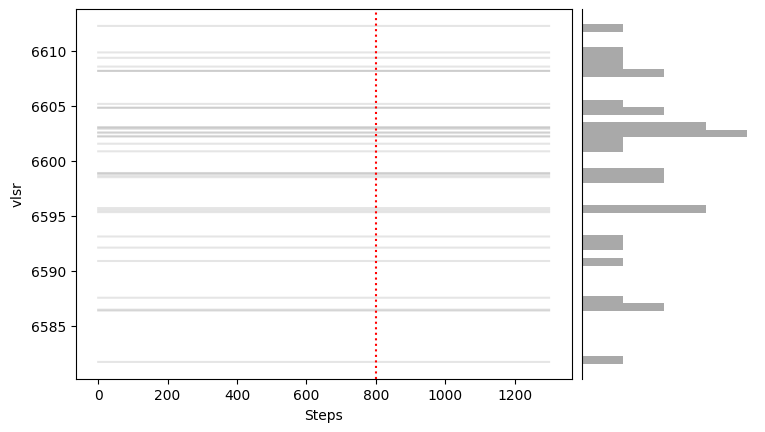

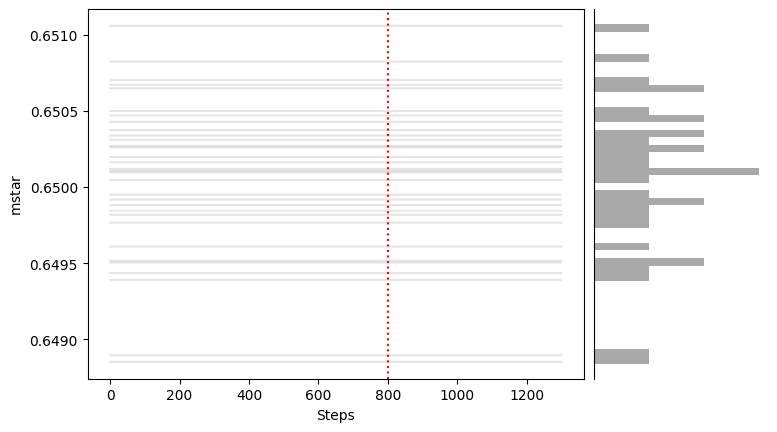

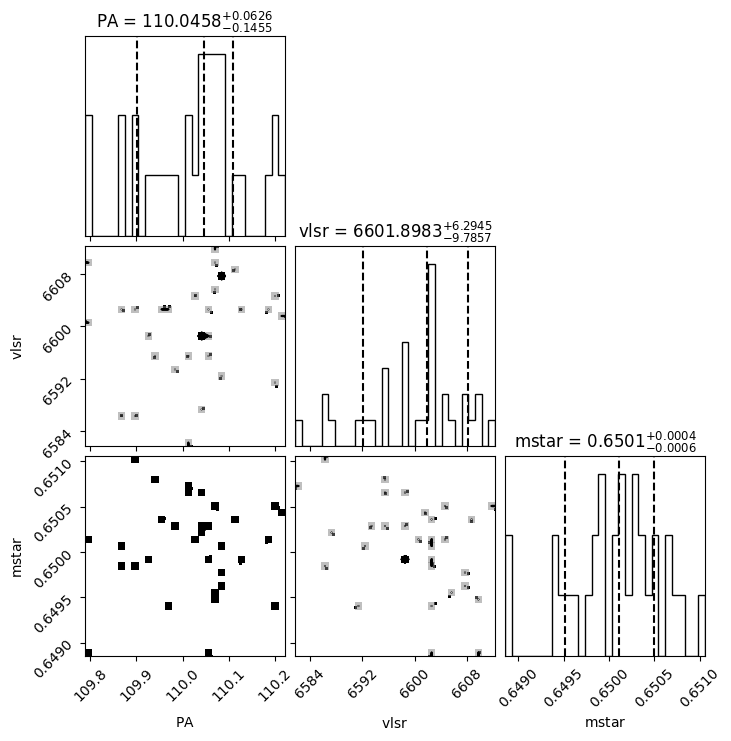

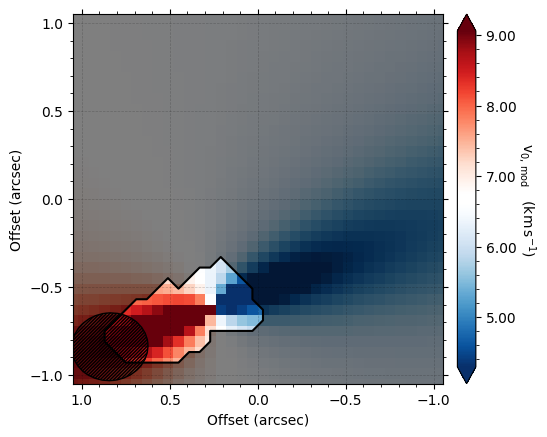

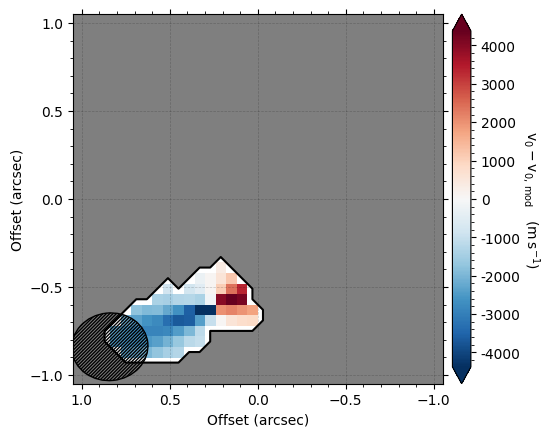

In [265]:
nwalkers, nburn, nsims = 32, 800, 500, 
rmin, rmax = .02, 1


PA_guess = 110
vlsr_guess = 6.6

move_stretch = -1
scatter = 1e-3


samples, params, resid_fig = run_eddy_mcmc(masked_cube, offsets, (rmin,rmax), PA_guess, vlsr_guess, nwalkers, nburn, nsims, move_stretch, scatter)


In [266]:
comment = 'MCMC FAILS'

region = infile.split('/')[-2]
name = infile.split('/')[-1].split('_')[0]

lit_inc = disk_dict[region][name]['inclination']

if lit_inc != '--' and lit_inc != 0:
    eddy_vlsr = np.round(np.median([x[1] for x in samples])/1000,2)
    eddy_mstar = np.round(np.median([x[2] for x in samples]),2)
    eddy_inc ='--'
else:
    eddy_vlsr = np.round(np.median([x[1] for x in samples])/1000,2)
    eddy_mstar = '--'
    eddy_inc = np.round(np.median([x[2] for x in samples]),2)


disk_row = {
    'Name': name,
    'Region': region,
    'File': infile,
    'Emmision Line': infile.split('/')[-1].split('_')[1],
    'Channels': channels,
    'X-pos': np.round(disk_dict[region][name]['RA'],6),
    'Y-pos': np.round(disk_dict[region][name]['Dec'],6), 
    'X-offset': np.round(params['x0'],3),
    'Y-offset': np.round(params['y0'],3),
    'Literature PA': disk_dict[region][name]['PA'],
    'Eddy PA': np.round(np.median([x[0] for x in samples]),2),
    'Literature Mass [M]': disk_dict[region][name]['M_star'],
    'Eddy Mass [M]': eddy_mstar,
    'DECO Dict vsys [km/s]': disk_dict[region][name]['vsys'],
    'Eddy vlsr [m/s]': eddy_vlsr,
    'Literature Inc': np.round(disk_dict[region][name]['inclination'],2),
    'Eddy Inc': eddy_inc,
    'Literature Distance [Mpc]': disk_dict[region][name]['distance'],
    'Eddy rmin, rmax ["]': (params['r_min'],params['r_max']),
    'Eddy params (nwalkers, nburn, nsteps)': (nwalkers, nburn, nsims),
    'Velocity Mask': mask,
    'Notes': comment,
}

print(disk_row)
df_row = pd.DataFrame([disk_row])
df_row.head()

{'Name': 'J162738.3-243658', 'Region': 'ROph', 'File': '/Users/calebpainter/Downloads/DECO/fits_files/ROph/J162738.3-243658_CO_230.538GHz.image.fits', 'Emmision Line': 'CO', 'Channels': (120, 180, 120, 180), 'X-pos': np.float64(246.909617), 'Y-pos': np.float64(-24.616443), 'X-offset': np.float64(0.256), 'Y-offset': np.float64(-0.612), 'Literature PA': 16.1, 'Eddy PA': np.float64(110.05), 'Literature Mass [M]': 0.65, 'Eddy Mass [M]': np.float64(0.65), 'DECO Dict vsys [km/s]': 4.2, 'Eddy vlsr [m/s]': np.float64(6.6), 'Literature Inc': np.float64(69.58), 'Eddy Inc': '--', 'Literature Distance [Mpc]': 139.46, 'Eddy rmin, rmax ["]': (0.02, 1.0), 'Eddy params (nwalkers, nburn, nsteps)': (32, 800, 500), 'Velocity Mask': [0.6, 0.2, -20], 'Notes': 'MCMC FAILS'}


,Name,Region,File,Emmision Line,Channels,X-pos,Y-pos,X-offset,Y-offset,Literature PA,...,Eddy Mass [M],DECO Dict vsys [km/s],Eddy vlsr [m/s],Literature Inc,Eddy Inc,Literature Distance [Mpc],"Eddy rmin, rmax [""]","Eddy params (nwalkers, nburn, nsteps)",Velocity Mask,Notes
0,J162738.3-243658,ROph,/Users/calebpainter/Downloads/DECO/fits_files/...,CO,"(120, 180, 120, 180)",246.909617,-24.616443,0.256,-0.612,16.1,...,0.65,4.2,6.6,69.58,--,139.46,"(0.02, 1.0)","(32, 800, 500)","[0.6, 0.2, -20]",MCMC FAILS


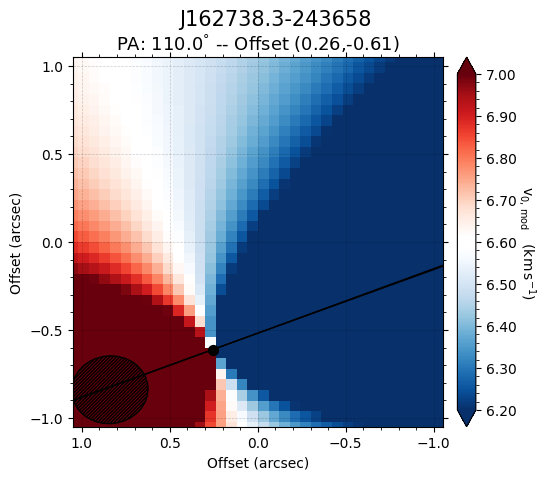

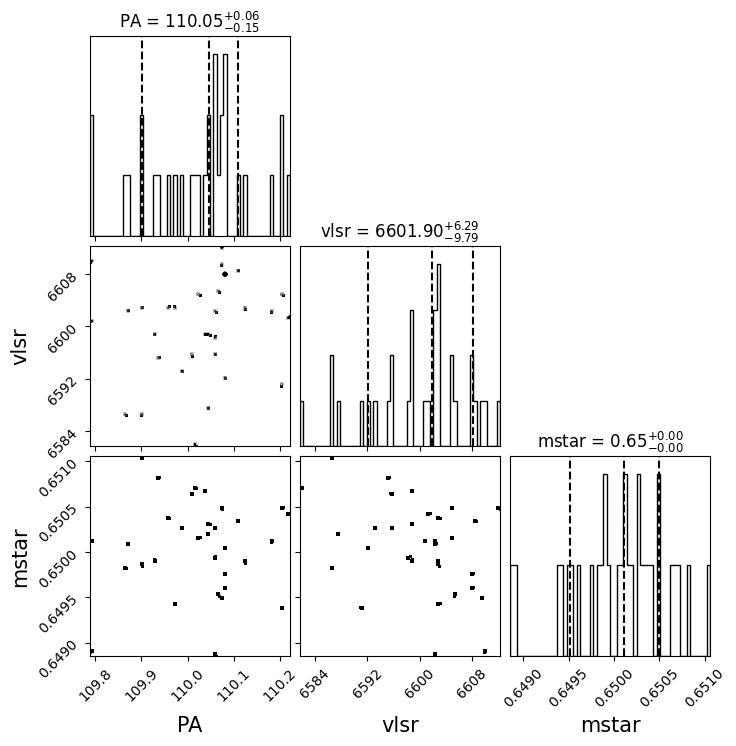

In [267]:
model_f, result_f, resid_f = plot_model_and_resids(samples, params, v_scaling, rot_fig, masked_no_bkg_rot_fig, resid_fig, disk_row, postage_stamp_fig, cont_fig)

In [268]:
df = pd.read_csv('DECO_disk_eddy_outputs.csv', index_col=0)
df

,Name,Region,File,Emmision Line,Channels,X-pos,Y-pos,X-offset,Y-offset,Literature PA,...,DECO Dict vsys [m/s],Eddy vlsr [m/s],"Eddy rmin, rmax [""]",Literature Distance [Mpc],Literature Inc,Eddy Inc,"Eddy params (nwalkers, nburn, nsteps)",Velocity Mask,Notes,DECO Dict vsys [km/s]
0,J162616.8-242223,ROph,/Users/calebpainter/Downloads/DustDrift2DiskMa...,CO,"(0, 200, 0, 200)",246.570167,-24.373279,0.710,-0.175,--,...,NaN,4.00,"(0.2, 2.0)",137.42,--,20.0,"(10, 500, 500)",NaN,"Too many clouds, eddy fails. Location is off?",4.50
1,J162624.1-241613,ROph,/Users/calebpainter/Downloads/DustDrift2DiskMa...,CO,"(30, 70, 130, 180)",246.600320,-24.270566,-0.131,-0.467,7.0,...,NaN,3.18,"(0.2, 2.0)",139.26,0,48.38,"(10, 500, 500)","[1.05, 0.9, 45]","Too many clouds, eddy fails. Location is off?",3.40
2,J162636.8-241552,ROph,/Users/calebpainter/Downloads/DustDrift2DiskMa...,CO,"(30, 80, 130, 190)",246.653428,-24.264589,0.438,0.107,61.8,...,NaN,4.94,"(0.1, 0.5)",136.59,31.3025863798542,--,"(10, 800, 500)",NaN,"Small disk with lots of clouds around, but see...",6.10
3,J162649.0-243825,ROph,/Users/calebpainter/Downloads/DustDrift2DiskMa...,CO,"(40, 100, 130, 200)",246.704060,-24.640489,-0.237,-0.175,83.4,...,NaN,2.02,"(0.1, 0.5)",132.51,22.1153384572256,--,"(10, 800, 500)",NaN,"Small disk with lots of clouds around, FAILS",4.70
4,Sz96,Lupus,/Users/calebpainter/Downloads/DECO/fits_files/...,CO,"(10, 180, 10, 180)",242.052530,-39.142777,0.146,0.378,91.498,...,NaN,1.24,"(0.05, 1.7)",155.97,48.997,--,"(32, 800, 500)",NaN,Good Disk,4.70
5,Sz90,Lupus,/Users/calebpainter/Downloads/DECO/fits_files/...,CO,"(10, 180, 10, 180)",241.791868,-39.184402,0.150,0.383,8.837,...,NaN,4.95,"(0.0, 2.0)",160.37,52.37,--,"(32, 800, 500)","[0.8, 0.4, 135]",Good Disk,5.24
6,Sz68,Lupus,/Users/calebpainter/Downloads/DECO/fits_files/...,CO,"(50, 105, 150, 200)",236.303488,-34.291990,0.182,0.410,0.288,...,NaN,4.98,"(0.2, 2.0)",158.00,34.01,--,"(32, 800, 500)","[0.5, 1.2, 200]",Good Disk,2.60
8,J162738.3-243658,ROph,/Users/calebpainter/Downloads/DECO/fits_files/...,CO,"(120, 180, 120, 180)",246.909617,-24.616443,0.256,-0.612,16.1,...,NaN,4.00,"(0.02, 1.0)",139.46,69.58,--,"(32, 800, 500)","[0.6, 0.2, -20]",MCMC FAILS,4.20


In [269]:
df = pd.concat([df, pd.DataFrame([disk_row])], ignore_index=True)
df.to_csv('DECO_disk_eddy_outputs.csv')

## Old messy code

In [341]:
name = infile.split('/')[-1].split('_')[0]
region = infile.split('/')[-2]
region = 'ChaI'

hdul = fits.open(infile)  # open aa FITS file
hdr = hdul[0].header  # the primary HDU header
dec = hdr['CRVAL2']
ra = hdr['CRVAL1'] 


center_ra = disk_dict['ChaI'][name]['RA']
center_dec = disk_dict['ChaI'][name]['Dec']

ra_diff_arcsecond = (center_ra - ra) * (np.cos(center_dec * np.pi / 180))*3600
dec_diff_arcsecond = (center_dec - dec) * 3600


KeyError: 'ChaI'

In [347]:
hdr['CDELT2'] * 3600

0.039999999999996004

NameError: name 'm1' is not defined

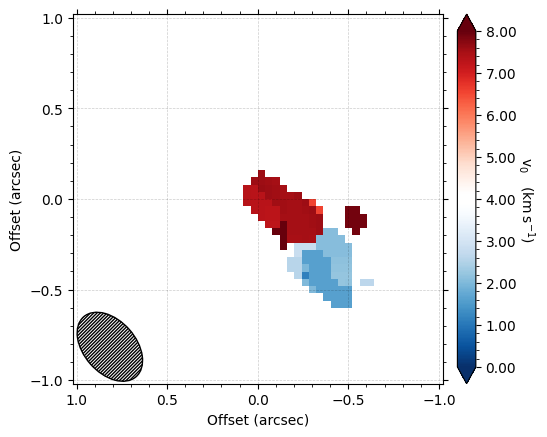

In [10]:
## do Eddy stuff
name = infile.split('/')[-1].split('_')[0]
cube = rotationmap(path=f'{infile[:-5]}_v0.fits',
                   uncertainty=f'{infile[:-5]}_dv0.fits',
                   FOV=2.0)
rot_fig = cube.plot_data(vmin=0, vmax=8, return_fig=True)
rot_axes_list = rot_fig.axes
rot_axes_list[0].set_title('Channels: '+f'{m1}-{m2},{m3}-{m4}')
rot_fig.suptitle(name)
rot_axes_list[0].scatter(ra_diff_arcsecond, dec_diff_arcsecond, color='black',s=20)

print(name)
# plt.savefig(f'/Users/calebpainter/Downloads/DECO/disk_plots_v/rotation_cube_map_{name}.png')

In [1116]:
# Dictionary to contain the disk parameters.

mass_prior =  center_ra = disk_dict['ChaI'][name]['M_star']
distance =  center_ra = disk_dict['ChaI'][name]['distance']

params = {}

# Start with the free variables in p0.
params['x0'] = ra_diff_arcsecond
params['y0'] = dec_diff_arcsecond
params['PA'] = 0
params['mstar'] = 1
params['vlsr'] = 2

# Provide starting guesses for these values.


# Fix the other parameters. All values which are to be fixed must be floats.

params['inc'] = 3 # degrees
params['dist'] = distance   # parsec

p0 = [320, mass_prior, 4e3, 20]



Assuming:
	p0 = [PA, mstar, vlsr, inc].
Starting positions:
	p0 = ['3.20e+02', '5.44e-01', '4.00e+03', '2.00e+01']


100%|██████████| 2000/2000 [01:26<00:00, 23.02it/s]


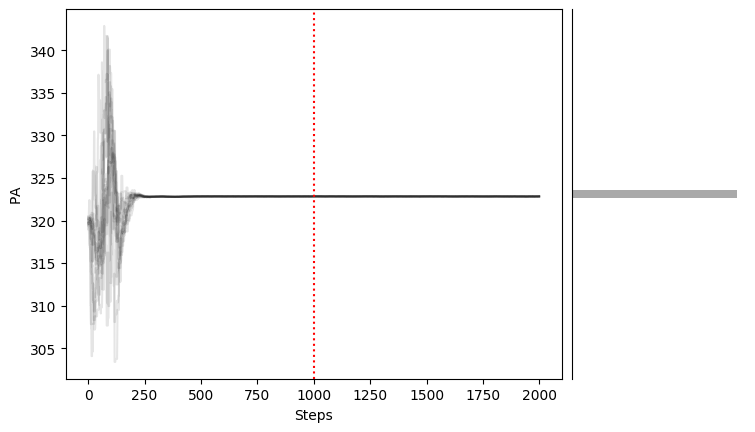

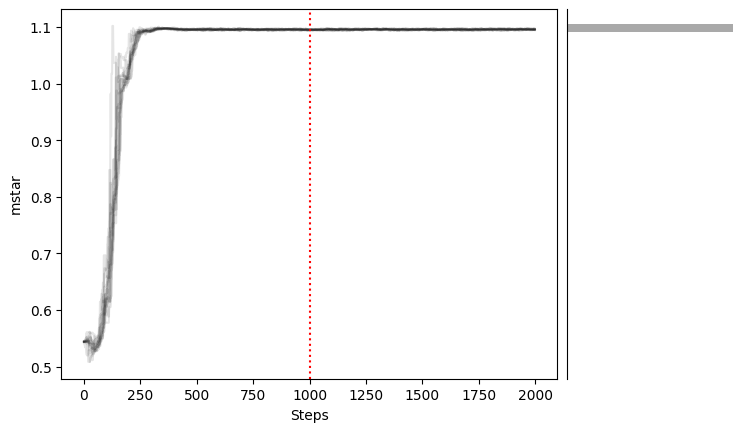

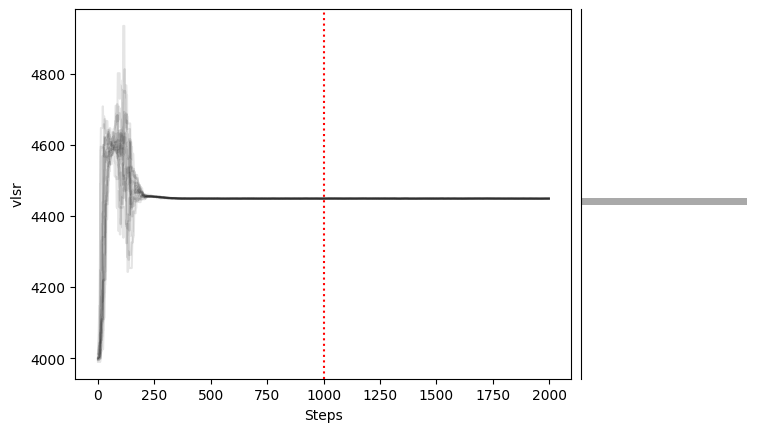

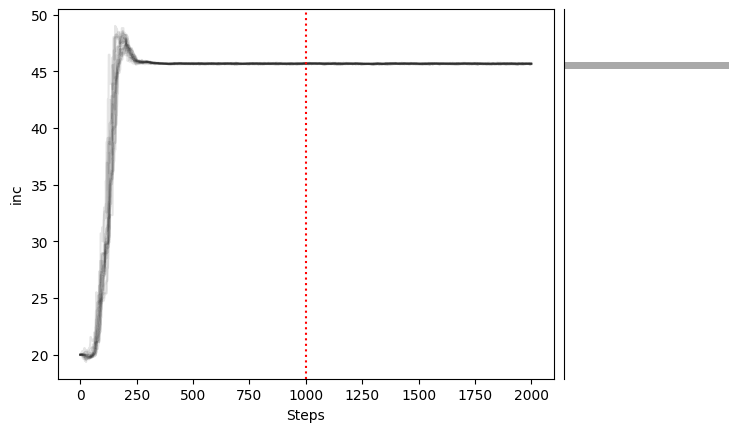

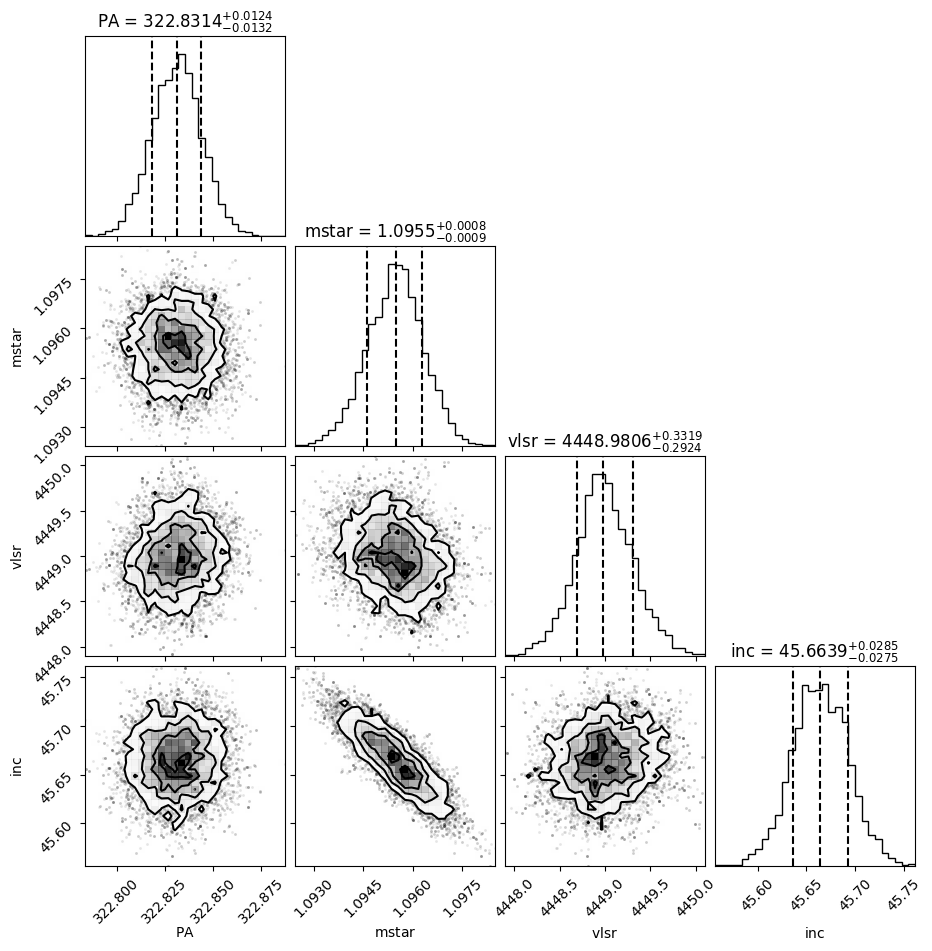

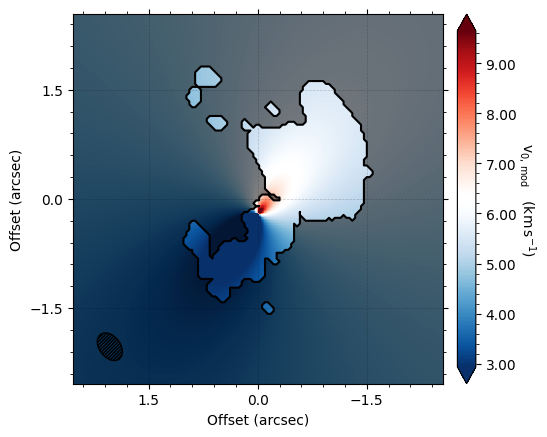

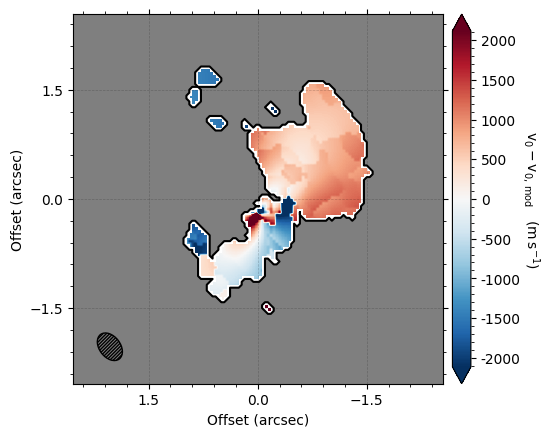

In [1092]:
nsims = 1000
nwalkers = 15

samples = cube.fit_map(p0=p0, params=params,
                       nwalkers=nwalkers, nburnin=1000, nsteps=nsims)

In [1094]:
# x_offset = np.median([x[0] for x in samples])
# y_offset = np.median([x[1] for x in samples])


PA = np.median([x[0] for x in samples])
M_star = np.median([x[1] for x in samples])
vlsr = np.median([x[2] for x in samples])

try:
    inc = np.median([x[3] for x in samples])
except:
    inc = params['inc']


PA_err_plus, PA_err_minus = np.percentile([x[0] for x in samples],84), np.percentile([x[0] for x in samples],16)

print(x_offset, ',', y_offset,',', PA, ',',(PA_err_plus-PA, PA-PA_err_minus),",",inc,',',(m1,m2,m3,m4))

322.83143469658614 , 1.0954854651279098 , 322.83143469658614 , (0.012393039886660517, 0.013244765532760994) , 45.66386960690285 , (0, 85, 120, 150)


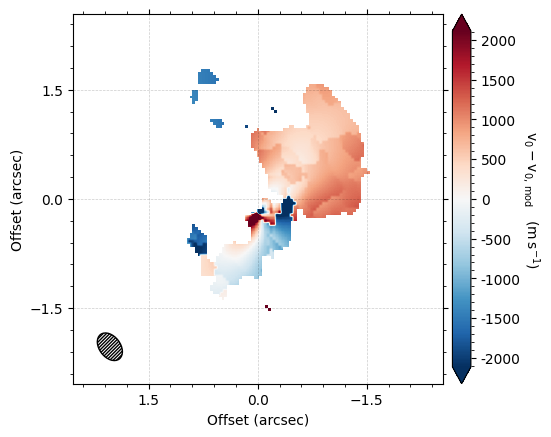

In [1095]:
model = cube.evaluate_models(samples=samples, params=params)

resid_fig = cube.plot_model_residual(model=model, return_fig=True, imshow_kwargs = {'vmin':})

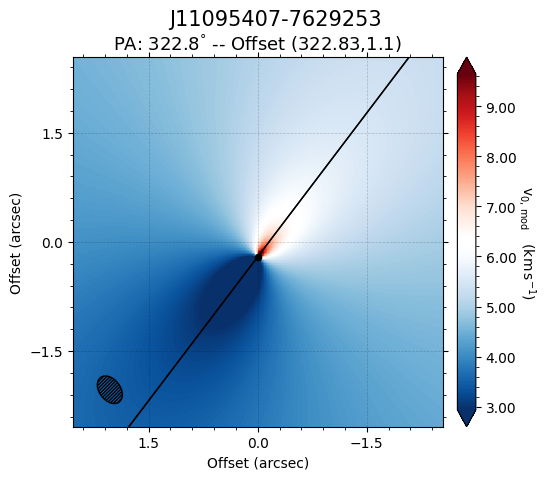

In [1096]:
model = cube.evaluate_models(samples=samples, params=params)
model_fig = cube.plot_model(model=model, return_fig = True,imshow_kwargs = {'vmin': 1.5})


axes_list = model_fig.axes

PA_slope = np.tan((PA+90)*np.pi / 180)
PA_slope_plus = np.tan((PA_err_plus+90)*np.pi / 180)
PA_slope_minus = np.tan((PA_err_minus+90)*np.pi / 180)


x= np.arange(-5,5,.1)
PA_line = -x * PA_slope
PA_line_plus = -x * PA_slope_plus
PA_line_min = -x * PA_slope_minus

axes_list[0].scatter(ra_diff_arcsecond, dec_diff_arcsecond, color='black',s=20)

axes_list[0].plot(x+ra_diff_arcsecond,PA_line_plus+dec_diff_arcsecond,color='black',linewidth=1)
axes_list[0].plot(x+ra_diff_arcsecond,PA_line_min+dec_diff_arcsecond,color='black',linewidth=1)


model_fig.suptitle(f"{infile.split('/')[-1].split('_')[0]}",fontsize=15)
axes_list[0].set_title(f"PA: {np.round(PA,1)}$^\degree$"+f" -- Offset ({np.round(x_offset,2)},{np.round(y_offset,2)})", fontsize=13,pad=5)
axes_list[0].scatter(x_offset,y_offset,s=50,color='black')
name = infile.split('/')[-1].split('_')[0]


# plt.savefig(f'/Users/calebpainter/Downloads/DECO/disk_plots_v/{name}.png')

In [1099]:
params.keys()

dict_keys(['x0', 'y0', 'PA', 'mstar', 'vlsr', 'inc', 'dist'])

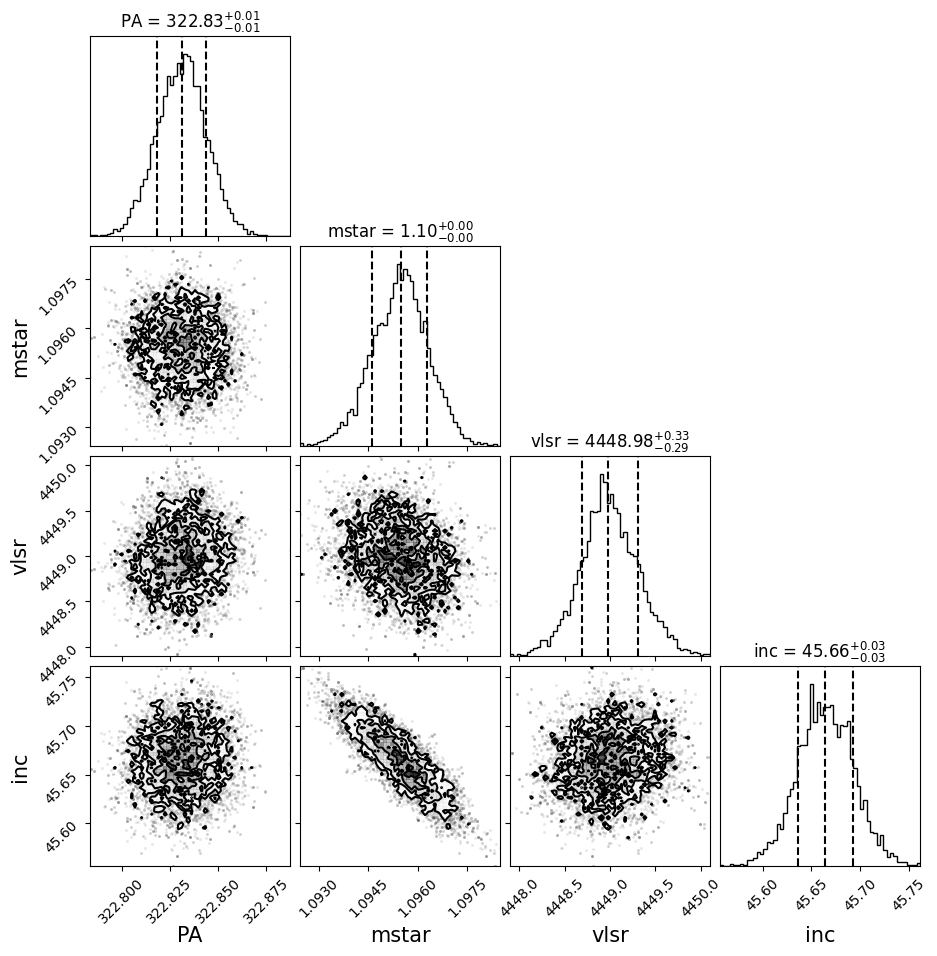

In [1101]:
corner_fig = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], labels=[l for l in list(params.keys())[2:6]], label_kwargs={"fontsize": 15}, show_titles=True, bins= 60)
rot_axes_list[0].plot(x+x_offset,PA_line_plus+y_offset,color='black',linewidth=1)
rot_axes_list[0].plot(x+x_offset,PA_line_min+y_offset,color='black',linewidth=1)


figs = [model_fig, rot_fig,resid_fig,corner_fig] # list of figures
with PdfPages(f'/Users/calebpainter/Downloads/DECO/disk_plots_v/full_diagnostic_{name}_{nsims}_sim_{nwalkers}_walkers.pdf') as pdf:
    for fig in figs:
        pdf.savefig(fig, bbox_inches='tight') 

## Continuum Inclination

In [965]:
import os

In [40]:
file_dir = '/Users/calebpainter/Downloads/products/new'
file_dirs = os.listdir(file_dir)
all_cont_files = []
for fdir in file_dirs:
    try:
        new_dir = file_dir+'/'+fdir+'/cont_images/'
        region_files = os.listdir(new_dir)
        all_cont_files.append(region_files)
    except:
        pass

In [46]:
CW

'J10590108-7722407'

In [60]:

file_dir = '/Users/calebpainter/Downloads/products/new'
file_dirs = os.listdir(file_dir)
all_cont_files = []
for fdir in file_dirs:
    try:
        new_dir = file_dir+'/'+fdir+'/cont_images/'
        region_files = os.listdir(new_dir)
        all_cont_files.append([new_dir + x for x in region_files])
    except:
        pass

disk_cont_file = None

for sublist in all_cont_files:
    for item in sublist:
        if name in item:
            disk_cont_file = item


In [61]:
all_cont_files

[['/Users/calebpainter/Downloads/products/new/Taurus_CCH_setting/cont_images/member.uid___A001_X2d20_X1f3d.CW_Tau_sci.spw25_27_29_31_33_35_37_39_41_43.cont.I.pbcor.fits',
  '/Users/calebpainter/Downloads/products/new/Taurus_CCH_setting/cont_images/member.uid___A001_X2d20_X1f3d.DL_Tau_sci.spw25_27_29_31_33_35_37_39_41_43.cont.I.pbcor.fits',
  '/Users/calebpainter/Downloads/products/new/Taurus_CCH_setting/cont_images/member.uid___A001_X2d20_X1f3d.DG_Tau_sci.spw25_27_29_31_33_35_37_39_41_43.cont.I.pbcor.fits',
  '/Users/calebpainter/Downloads/products/new/Taurus_CCH_setting/cont_images/member.uid___A001_X2d20_X1f3a.DS_Tau_sci.spw25_27_29_31_33_35_37_39_41_43.cont.I.pbcor.fits',
  '/Users/calebpainter/Downloads/products/new/Taurus_CCH_setting/cont_images/member.uid___A001_X2d20_X1f3d.GK_Tau_sci.spw25_27_29_31_33_35_37_39_41_43.cont.I.pbcor.fits',
  '/Users/calebpainter/Downloads/products/new/Taurus_CCH_setting/cont_images/member.uid___A001_X2d20_X1f3d.HO_Tau_sci.spw25_27_29_31_33_35_37_39_

/Users/calebpainter/Downloads/fits_downloads/J162713.7-241817_C18O_219.56GHz.image.fits


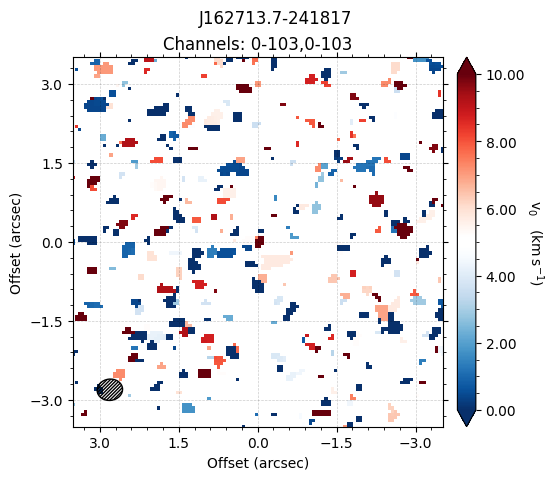

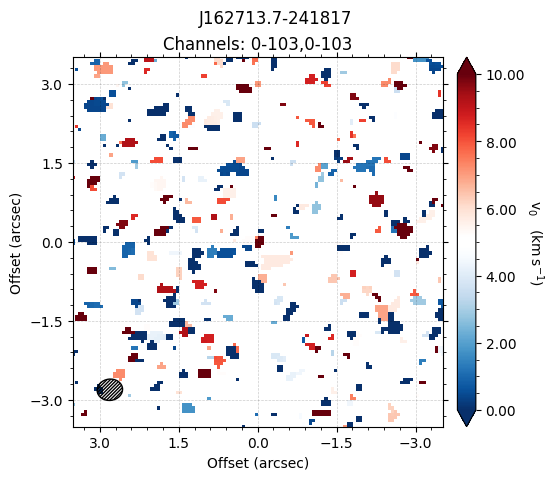

In [1012]:
file_number = 20
file_path = file_dir + file_paths[file_number]
print(file_path)

create_velocity_map(file_path,('full',0),3)


In [304]:
center_ra = disk_dict['ChamI'][name]['RA']
center_dec = disk_dict['ChamI'][name]['Dec']

# print(center_ra, center_dec)
print(Angle(center_ra * u.degree).hms,Angle(center_dec * u.degree).dms)

test_ra, test_dec = Angle('10:59:01.2301819678 hours').degree, Angle('-77:22:41.6674516505 degrees').degree
test_ra, test_dec

hms_tuple(h=10.0, m=59.0, s=0.9187000000009959) dms_tuple(d=-77.0, m=-22.0, s=-40.91459999996687)


(164.75512575819914, -77.37824095879179)